In [36]:
import sqlite3

import pandas as pd
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')
from sklearn.metrics.pairwise import euclidean_distances

conn = sqlite3.connect("../week1/Data/go_sales_train.sqlite")
sales_conn = conn.cursor()

In [37]:
product = pd.read_sql_query("SELECT * FROM order_details", conn)
product2 = pd.read_sql_query("SELECT * FROM product", conn)

In [38]:
order = product.loc[:]
order = pd.merge(product2, order, on='PRODUCT_NUMBER')
#retailer.drop(columns={"PRODUCT_NUMBER"}, axis=1, inplace=True)
order["TOTAL_PRICE"] = order["UNIT_PRICE"] * order["QUANTITY"]
order.loc[:, ["PRODUCT_NUMBER", "QUANTITY", "TOTAL_PRICE"]]


,PRODUCT_NUMBER,QUANTITY,TOTAL_PRICE
0,1,84,553.56
1,1,126,830.34
2,1,122,803.98
3,1,122,803.98
4,1,272,1792.48
...,...,...,...
37752,115,52,556.92
37753,115,80,802.40
37754,115,36,361.08
37755,115,24,240.00


In [39]:
eis = order["TOTAL_PRICE"] < 150000
df_2d = order.loc[eis, ["PRODUCT_NUMBER", "QUANTITY", "TOTAL_PRICE"]]
df_2d

,PRODUCT_NUMBER,QUANTITY,TOTAL_PRICE
0,1,84,553.56
1,1,126,830.34
2,1,122,803.98
3,1,122,803.98
4,1,272,1792.48
...,...,...,...
37752,115,52,556.92
37753,115,80,802.40
37754,115,36,361.08
37755,115,24,240.00


In [40]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit_predict(df_2d)

array([0, 0, 0, ..., 0, 0, 0], shape=(37738,), dtype=int32)

In [41]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1,2
0,58.808482,50.749769,2399.006842
1,28.183007,121.529412,75714.278039
2,42.215503,55.405279,19676.428039


In [42]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})

kmeans_centra

,PRODUCT_NUMBER,QUANTITY,TOTAL_PRICE
0,58.808482,50.749769,2399.006842
1,28.183007,121.529412,75714.278039
2,42.215503,55.405279,19676.428039


In [43]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    #print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        #print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            #print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2

        #print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        #print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        #print('------------------------------------------------')

    #print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    #print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    #print("================================================")

df_2d

,PRODUCT_NUMBER,QUANTITY,TOTAL_PRICE,Centrum
0,1,84,553.56,0.0
1,1,126,830.34,0.0
2,1,122,803.98,0.0
3,1,122,803.98,0.0
4,1,272,1792.48,0.0
...,...,...,...,...
37752,115,52,556.92,0.0
37753,115,80,802.40,0.0
37754,115,36,361.08,0.0
37755,115,24,240.00,0.0


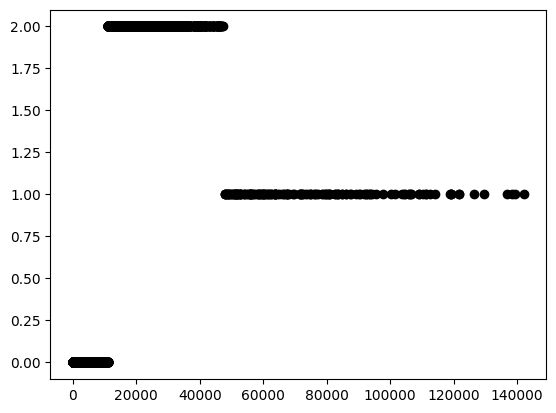

In [44]:
plt.scatter(df_2d['TOTAL_PRICE'], df_2d['Centrum'], color = 'k')
plt.show()

In [45]:
df_2d.groupby('Centrum', as_index = False)['Centrum'].count()
order["Centrum"] = df_2d["Centrum"]
order["Prijsklasse"] = df_2d["Centrum"].map({
    0: "laag",
    2: "gemiddeld",
    3: "hoog"
})
order["Prijsklasse"] = pd.Categorical(order["Prijsklasse"], categories=["laag", "gemiddeld", "hoog"], ordered=True)

aantallen = order.groupby(['PRODUCT_NAME', 'Prijsklasse'], as_index=False).size().rename(columns={'size': 'AANTAL'})

aantallen = aantallen.sort_values(by=['PRODUCT_NAME', 'Prijsklasse'])

aantallen

,PRODUCT_NAME,Prijsklasse,AANTAL
0,Aloe Relief,laag,294
1,Aloe Relief,gemiddeld,0
2,Aloe Relief,hoog,0
3,Bear Edge,laag,390
4,Bear Edge,gemiddeld,1
...,...,...,...
340,TrailChef Utensils,gemiddeld,0
341,TrailChef Utensils,hoog,0
342,TrailChef Water Bag,laag,419
343,TrailChef Water Bag,gemiddeld,0


In [51]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
prediction_results = kmeans.fit_predict(order)
prediction_results

ValueError: could not convert string to float: '1995-02-15'